# Filtering of hierarchies of partitions with Higra

Higra (Hierarchical Graph Analysis) is a python library designed to apply and develop new methods for hierarchical graph analysis.

Higra's frontend is written in Python to favor ease of use and rapid developpement while it's core functions are written in c++ to ensure high performances. 

This tutorial will show you how to filter a hierarchy of partitions of an image. It is composed of 3 sections:

1. Creation of a trivial hierarchy from an image
2. Filtering of the hierarchy with various attributes
3. Visualization of the results

## Creation of a trivial hierarchy from an image

Higra integrates seamlessly with Numpy and all associated packages: we will thus rely on them for basic image manipulations.

Let's start with a bunch of imports...

In [1]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
from utils import * # tic toc imshow

import higra as hg

We will process a classical image from BSDS.

Image size: (481, 321)


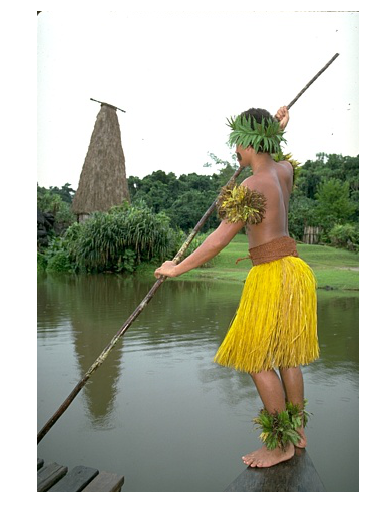

In [2]:
image = imageio.imread("data/101087.jpg")
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float64)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

### Graph creation

The image will be represented as an edge weighted graph with a simple RGB gradient.

Let's start by creating a 4 adjacency pixel graph. 

In [3]:
graph = hg.get_4_adjacency_graph(size)


Note that at any moment we can get some help on the function with the `help` command:

In [4]:
help(hg.get_4_adjacency_graph)

Help on function get_4_adjacency_graph in module graph_image:

get_4_adjacency_graph(shape)
    Create an explicit undirected 4 adjacency graph of the given shape.
    :param shape: pair (height, width)
    :return: Graph (with attribute "shape")



Now, let's compute edge weights, Higra propose some helper functions to do this efficiently for common weighting functions:

In [5]:
image_flatten = image.reshape((-1,3)) # spatial dimensions of the image are irrelevant and must be flatten 
edge_weights = hg.weight_graph(graph, image_flatten, hg.WeightFunction.L2)

We can plot this gradient in Khalimsky space in order to see how it looks like.

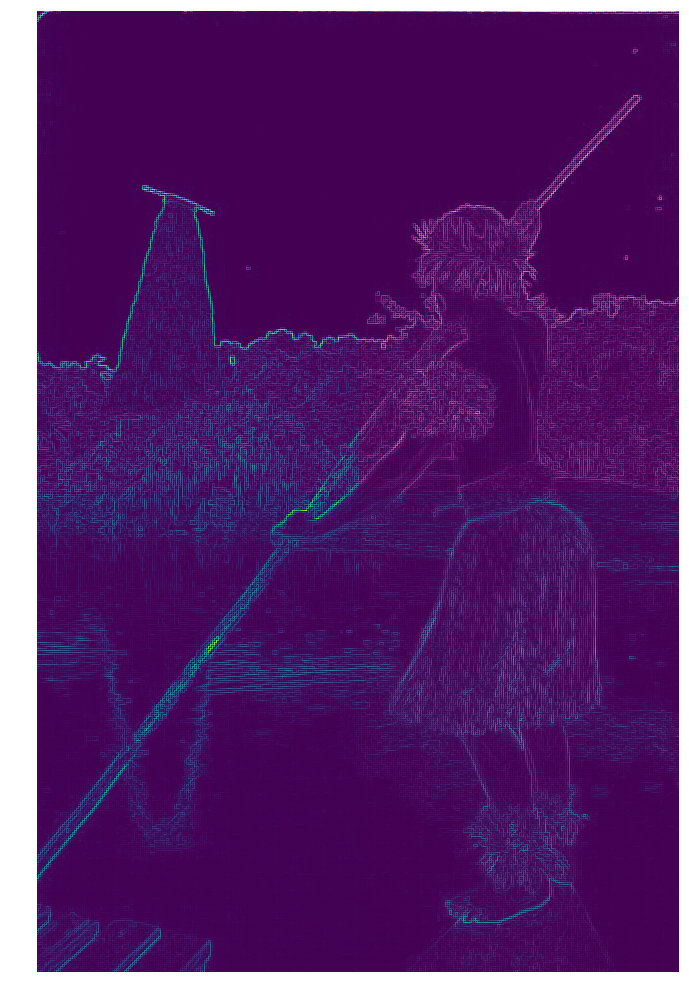

In [6]:
gradient = hg.contour2khalimsky(graph, size, edge_weights)
imshow(gradient)

Note that Higra is designed to simplify data manipulation, and we could have simply written

```
gradient = hg.contour2khalimsky(graph)
```

the value of `size` and `edge_weights` are deduced from previous processings.

### Hierarchy of partition creation

As a demo-hierarchy, we will use the canonical binary partition tree by altitude ordering from the weighted graph:

In [7]:
tree = hg.bpt_canonical(graph)

In order to visualize the hierarchy we can compute its saliency map, i.e. for each edge of the base graph, compute the altitude of the smallest vertex of the tree that contains both extremities of the edge, and display the result in Khalimsky space, as we did for the gradient.

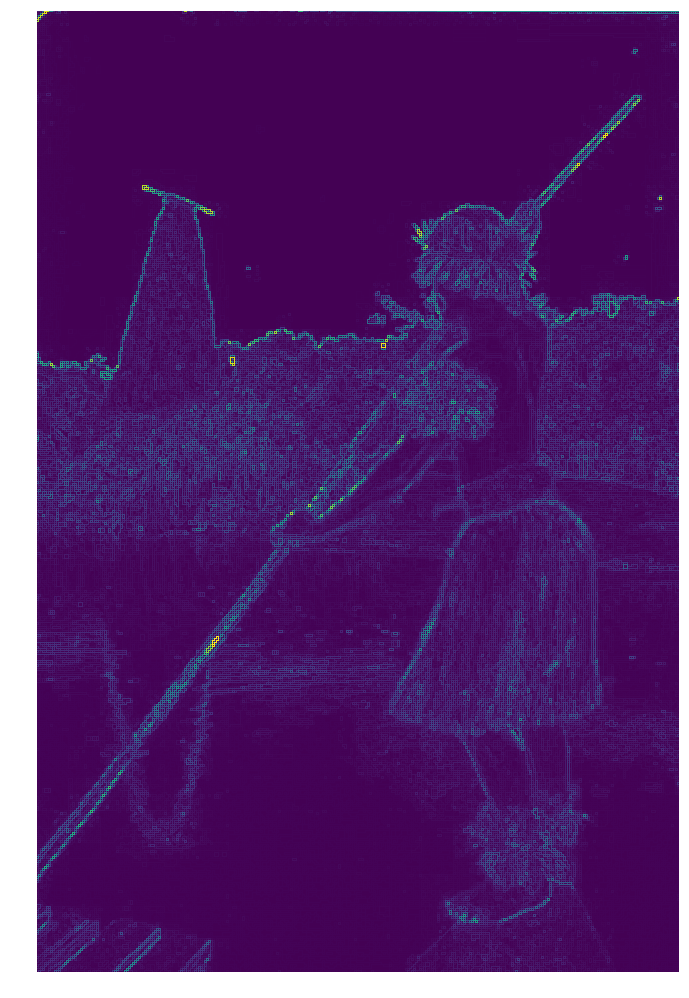

In [8]:
saliency = hg.saliency(tree)
imshow(hg.contour2khalimsky(graph, edge_weights=saliency))

This is not very nice and we will see in next section how to improve this hierarchy of partitions very easily


## Hierarchy filtering

The idea of hierarchy filtering is very simple. 
Each node of the binary partition tree represent the separation between its two children.
If we identify that one of the children of a node is not relevant, according to a given measure, then the separation is not relevant either: it must be set to 0. Thus, we will erase some frontiers involving non relevant nodes which will give us a new filtered gradient from which a new hierarchy can be constructed.

### Filtering criterion

The simplest way to identify non relevant nodes is to use their size: small nodes are irrelevant.

In [9]:
area = hg.attribute_area(tree)

The frontier represented by a node will be deleted if one of its children has an area lower than a given threshold. To get this information we will compute for each node the minimum of the area of its children and compare it to the threshold.

We can do this in Python using the low level API of Higra to code it "à la" C

In [10]:
#%%timeit
deleted_frontiers = np.empty((tree.num_vertices(),), dtype=np.bool) # create an array to store the result

threshold = 100

for i in tree.iterate_from_leaves_to_root(include_leaves=False):
    min_area = tree.num_leaves()
    
    for c in tree.children(i):
        min_area = min(min_area, area[c])
    
    deleted_frontiers[i] = min_area < threshold

While this may be fine for prototyping and experiments, this solution is inefficient in terms of computation time. 

Higra provides several convenience functions to "move" values up and down efficiently along the tree. In this case, we want to accumulate children values (with a "min" accumulator") in parallel (we do not use the result of the computation at a given node to compute the result of its parent). 

In [11]:
#%%timeit

min_children = tree.accumulate_parallel(area, hg.Accumulators.min)
deleted_frontiers_fast = min_children < threshold


Normaly, if you remove the comment from the `timeit` command in the 2 previous cells and rerun them, the timing should show you that the second solution si about 10 times faster

### Tree nodes reweighting

We will set the altitude of the deleted nodes to 0, which intuitively corresponds to erasing the frontier between the two children of the deleted node.

In [12]:
# Higra implements a data store to associate attribute to objects
# The altitudes attribute was set during the tree construction by the bptCanonical method
altitudes = hg.get_attribute(tree, "altitudes")

new_altitudes = altitudes.copy()
new_altitudes[deleted_frontiers_fast] = 0

### Minimum spanning tree reweighting

Now the magic happens! The inner nodes of the canonical binary partition tree of a graph are in bijection with the edges of one minimum spanning tree of the image graph. We are going to transfert the new altitudes of the nodes of the tree to the minimum spanning tree to get a new edge-weighted graph. 

In [13]:
# The mst attribute was also set during the tree construction by the bptCanonical method
mst = hg.get_attribute(tree, "mst")

# the edge-weights of the mst are simply the altitudes of the inner-nodes of the bpt
mst_edge_weights = new_altitudes[tree.num_leaves():]

### Filtered hierarchy construction
Finally it remains to compute the canonical binary partition tree of the new edge-weighted graph:

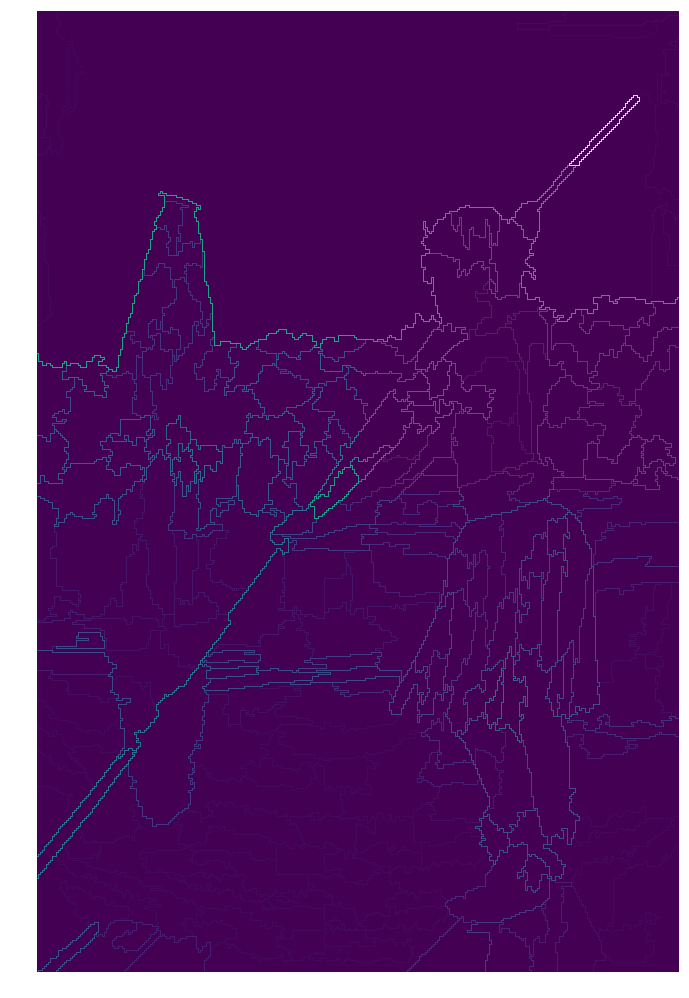

In [14]:
filtered_tree = hg.bpt_canonical(mst, mst_edge_weights)

imshow(hg.contour2khalimsky(graph, edge_weights=hg.saliency(filtered_tree)))

## Better visualization

So far, we have visualized partition hierarchies using saliency maps (or ultra-metric contour maps) in the 2D Khalimsky space.

This kind of representation can be misleading and it is sometimes interesting to visualize the different paritions composing the hierarchy.

We are going to build a small interractive plot to explore a hierarchy partition by partition.

### Horizontal cuts

A hierarchy of partitions encodes a large number of possible partitions. Here, we will restruct ourselves to the horizontal cuts of the hierarchy, i.e. partitions that corresponds to a threshold of the saliency map.

An intuitive approach to this problem is to search for the horizontal cut that contains `k` regions. Here, we compute for each node the smallest number `k` such that the region that corresponds to this node belongs to the partition in `k` regions.

In [15]:
# probably a little magic here!
# num_regions_in_horizontal_cut = [...5, 4, 3, 2]
num_regions_in_horizontal_cut = np.arange(filtered_tree.num_vertices() + 1, 1, -1)
# move values to children:
#   the two children of the root belong to the 2-partition
#   the two children of the (root-1)th node belong to the 3-partition
#   the two children of the (root-2)th node belong to the 4-partition
#   ...
num_regions_in_horizontal_cut = num_regions_in_horizontal_cut[filtered_tree.parents()]
# special case for the root
num_regions_in_horizontal_cut[-1] = 1

### Partition

A partition will be represented as an image where the color of each region is given by the mean color of the original image pixels in this region.

In [17]:
mean_color = hg.attribute_mean_weights(filtered_tree, leaf_data=image_flatten)

In order to get an image from a selected set of nodes from a tree, we can propagate their mean color values back to the pixels they contain.

With the low level API, such a function can be written as:

In [18]:
def reconstruct_leaf_data(deleted_nodes):
    reconstruction = np.zeros((filtered_tree.num_vertices(), 3))
    for i in filtered_tree.iterate_from_root_to_leaves():
        if deleted_nodes[i] and i != tree.root():
            reconstruction[i] = reconstruction[filtered_tree.parent(i)]
        else:
            reconstruction[i] = mean_color[i]
            
    return reconstruction[:tree.num_leaves()]
    

Thus if we want to reconstruct a partition with 50 regions

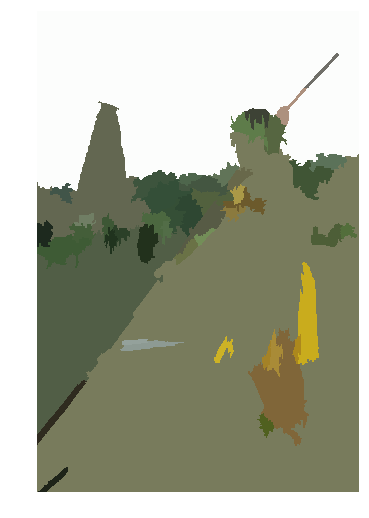

In [19]:
im = reconstruct_leaf_data(num_regions_in_horizontal_cut > 50)
im = im.reshape(image.shape)
imshow(im)

As before, the previous function can be written much more efficiently with a convenient accumulator:

In [20]:
def reconstruct_leaf_data_fast(deleted_nodes):
    im = filtered_tree.propagate_sequential(mean_color, deleted_nodes)
    return im[:tree.num_leaves()]


In this case you can observe a X5 speed-up using the accumulator

In [21]:
%timeit reconstruct_leaf_data(num_regions_in_horizontal_cut > 50)
%timeit reconstruct_leaf_data_fast(num_regions_in_horizontal_cut > 50)

534 ms ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
90.5 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Of course we obtain the same result

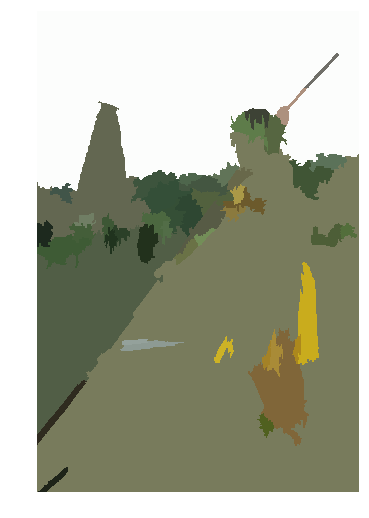

In [22]:
im = reconstruct_leaf_data_fast(num_regions_in_horizontal_cut > 50)
im = im.reshape(image.shape)
imshow(im)

Finally, we can use the notebook features to get a nice interractive figure:

In [24]:
from ipywidgets import  interact, widgets, IntSlider

def horizontal_cut(num_regions):
    im = reconstruct_leaf_data_fast(num_regions_in_horizontal_cut > num_regions)
    im = im.reshape(image.shape)
    imshow(im)
    
interact(horizontal_cut, num_regions=IntSlider(value=50, min=1, max=100, step=1, continuous_update=False));

interactive(children=(IntSlider(value=50, continuous_update=False, description='num_regions', min=1), Output()), _dom_classes=('widget-interact',))